In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May  5 11:17:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import logging

In [ ]:
#logging 

# create run_lof folder if not exist
if not os.path.exists('/content/drive/MyDrive/DLCV_CW3/run_logs/'):
    os.mkdir('/content/drive/MyDrive/DLCV_CW3/run_logs/')


Log_Format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename = "/content/drive/MyDrive/DLCV_CW3/run_logs/vgg_"+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+".log",
                    filemode = "w",
                    format = Log_Format, 
                    level = logging.ERROR)

logger = logging.getLogger()

# Load and normalize MNIST

In [ ]:
logger.info("Loading MNIST dataset") 

mnist_data_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_data/'
mnist_save_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_VGG_results/'
mnist_fig_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_VGG_figures/'

# create folder if not exist
if not os.path.exists(mnist_save_dir):
    os.mkdir(mnist_save_dir)

if not os.path.exists(mnist_fig_dir):
    os.mkdir(mnist_fig_dir)

In [ ]:
logger.info("Transforming MNIST dataset") 

mnist_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_train_data = datasets.MNIST(root=mnist_data_dir, train=True, transform=mnist_transform, download=True)

val_size = int(len(mnist_train_data) * 0.2)
train_size = len(mnist_train_data) - val_size

mnist_train_data, mnist_val_data = random_split(mnist_train_data, [train_size, val_size])
mnist_train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

mnist_val_loader = DataLoader(dataset=mnist_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

mnist_test_data = datasets.MNIST(root=mnist_data_dir, train=False, transform=mnist_transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

# Visualising the MNIST data 

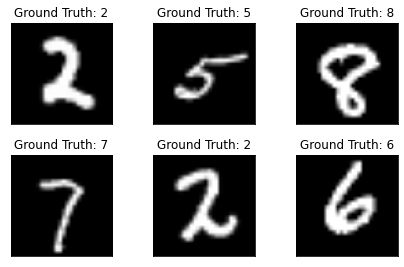

In [ ]:
logger.info("Visualising MNIST dataset") 

examples = enumerate(mnist_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


# Load and normalize CIFAR10


In [ ]:
logger.info("Loading Cifar dataset") 

cifar_data_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_data/'
cifar_save_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_VGG_results/'
cifar_fig_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_VGG_figures/'

# create folder if not exist
if not os.path.exists(cifar_save_dir):
    os.mkdir(cifar_save_dir)

if not os.path.exists(cifar_fig_dir):
    os.mkdir(cifar_fig_dir)

In [ ]:
logger.info("Transforming CIFAR dataset") 

cifar_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_train_data = datasets.CIFAR10(root=cifar_data_dir, train=True, transform=cifar_transform, download=True)

val_size = int(len(cifar_train_data) * 0.2)
train_size = len(cifar_train_data) - val_size

cifar_train_data, cifar_val_data = random_split(cifar_train_data, [train_size, val_size])
cifar_train_loader = DataLoader(dataset = cifar_train_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_val_loader = DataLoader(dataset = cifar_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_test_data = datasets.CIFAR10(root=cifar_data_dir, train=False, transform=cifar_transform)
cifar_test_loader = DataLoader(dataset = cifar_test_data, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


# Visualising the CIFAR data 

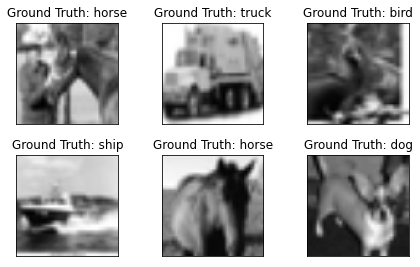

In [ ]:
logger.info("Visualising CIFAR dataset") 

examples = enumerate(cifar_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(cifar_classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


# VGG16 Model Class

In [ ]:
class VGG16(nn.Module):
    def __init__(self, input_channels = 3, num_classes = 10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512*7*7, 4096)  #2048
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1_1(x))
        x = nn.functional.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv2_1(x))
        x = nn.functional.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv3_1(x))
        x = nn.functional.relu(self.conv3_2(x))
        x = nn.functional.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv4_1(x))
        x = nn.functional.relu(self.conv4_2(x))
        x = nn.functional.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv5_1(x))
        x = nn.functional.relu(self.conv5_2(x))
        x = nn.functional.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, 0.5) 
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.fc3(x)
        return x

# Model Training Base Code 

In [ ]:
def train_model(model, model_log_path, train_loader, val_loader, loss_function, optimizer):
    
    writer = SummaryWriter(model_log_path)

    
    epochs = 10

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  
    model = model.to(device)


    # tracking variables
    train_hist = {}
    train_hist['model_train_losses'] = []
    train_hist['model_val_losses'] = []
    train_hist['model_val_accuracies'] = []
    train_hist['model_per_epoch_ptimes'] = []
    train_hist['model_total_ptime'] = []


    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        loss_train = []    
        epoch_start_time = time.time()
        for (image, target) in tqdm(train_loader):
            image = image.to(device)

            target = target.to(device)

            ## Forward Pass
            model_optimizer.zero_grad()
            scores = model(image)
            loss = loss_function(scores,target.to(device))
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        val_accuracy = 0
        val_loss = []
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for (image, target) in tqdm(val_loader):
                image = image.to(device)

                target = target.to(device)
                
                scores = model(image)
                loss = loss_function(scores,target.to(device)).item()
                _, predictions = scores.max(1)
                num_correct += (predictions == target.to(device)).sum()
                num_samples += predictions.size(0)
                val_loss.append(loss)
            val_accuracy = float(num_correct) / float(num_samples)

        epoch_loss_train = np.mean(loss_train)
        epoch_val_loss = np.mean(val_loss)
        epoch_val_accuracy = val_accuracy
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Training loss: %.8f, Validation loss: %.8f, Validation Accuracies: %.8f " % (epoch_loss_train, epoch_val_loss, epoch_val_accuracy))

        # record the loss for every epoch
        train_hist['model_train_losses'].append(epoch_loss_train)
        train_hist['model_val_losses'].append(epoch_val_loss)
        train_hist['model_val_accuracies'].append(epoch_val_accuracy)
        train_hist['model_per_epoch_ptimes'].append(per_epoch_ptime)
        
        writer.add_scalar("Loss/train", epoch_loss_train, epoch)
        writer.add_scalar("Loss/Val", epoch_val_loss, epoch)
        writer.add_scalar("Accuracy/val", epoch_val_accuracy, epoch)


    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['model_total_ptime'].append(total_ptime)
    
    writer.flush()
    
    writer.close()

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['model_per_epoch_ptimes']), epochs, total_ptime))
    
    
    return model, train_hist

In [ ]:
def test_model(model, test_loader, loss_function):
    
    num_correct = 0
    num_samples = 0

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  

    test_loss = []

    for (image, target) in tqdm(test_loader):
        image = image.to(device)

        target = target.to(device)
        
        scores = model(image)

        loss = loss_function(scores,target).item()

        _, predictions = scores.max(1)
        num_correct += (predictions == target).sum()
        num_samples += predictions.size(0)

        test_loss.append(loss)

    test_accuracy = float(num_correct) / float(num_samples)
    avg_test_loss = np.mean(test_loss)

    print("Testing loss: %.8f, Testing Accuracies: %.8f " % (avg_test_loss, test_accuracy))

    return test_loss


# Training MNSIT dataset on VGG

Already trained on VGG on mnist with lr=0.3 optimizer= Adam
Already trained on VGG on mnist with lr=0.3 optimizer= SGD
Already trained on VGG on mnist with lr=0.03 optimizer= Adam
Training VGG on mnist with lr=0.03 optimizer= SGD


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 1 of 10 with 367.64 s
Training loss: 2.30152393, Validation loss: 2.30166356, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 2 of 10 with 367.80 s
Training loss: 2.30135786, Validation loss: 2.30162945, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 3 of 10 with 367.98 s
Training loss: 2.30135222, Validation loss: 2.30158552, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.75it/s]


Epoch 4 of 10 with 368.33 s
Training loss: 2.30134687, Validation loss: 2.30143799, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.87it/s]


Epoch 5 of 10 with 367.94 s
Training loss: 2.30130689, Validation loss: 2.30140348, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 6 of 10 with 368.06 s
Training loss: 2.30130598, Validation loss: 2.30156625, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 7 of 10 with 368.07 s
Training loss: 2.30137365, Validation loss: 2.30155596, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 8 of 10 with 368.15 s
Training loss: 2.30133713, Validation loss: 2.30157752, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 9 of 10 with 368.15 s
Training loss: 2.30131200, Validation loss: 2.30177489, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.87it/s]


Epoch 10 of 10 with 368.04 s
Training loss: 2.30129490, Validation loss: 2.30140153, Validation Accuracies: 0.11175000 
Avg per epoch ptime: 368.02, total 10 epochs ptime: 3680.17
Training finish!... save and plotting training results


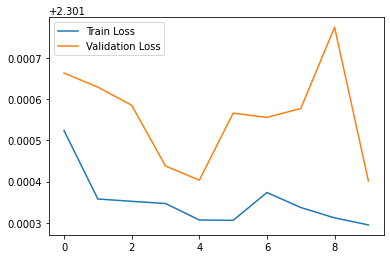

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30100722, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


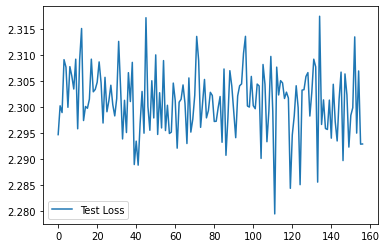

Training VGG on mnist with lr=0.003 optimizer= Adam


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 1 of 10 with 381.73 s
Training loss: 28.82960238, Validation loss: 2.30603393, Validation Accuracies: 0.10916667 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 2 of 10 with 381.81 s
Training loss: 2.30170271, Validation loss: 2.30280647, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 3 of 10 with 381.88 s
Training loss: 2.30156139, Validation loss: 2.30193761, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 4 of 10 with 381.98 s
Training loss: 2.30145485, Validation loss: 2.30185848, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 5 of 10 with 382.03 s
Training loss: 2.30152449, Validation loss: 2.30173049, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 6 of 10 with 381.85 s
Training loss: 2.30149497, Validation loss: 2.30142712, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 7 of 10 with 382.01 s
Training loss: 2.30150119, Validation loss: 2.30166500, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 8 of 10 with 381.80 s
Training loss: 2.30218814, Validation loss: 2.30292796, Validation Accuracies: 0.10991667 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 9 of 10 with 381.81 s
Training loss: 2.30312611, Validation loss: 2.30255685, Validation Accuracies: 0.11283333 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 10 of 10 with 381.90 s
Training loss: 2.30191716, Validation loss: 2.30229435, Validation Accuracies: 0.10983333 
Avg per epoch ptime: 381.88, total 10 epochs ptime: 3818.80
Training finish!... save and plotting training results


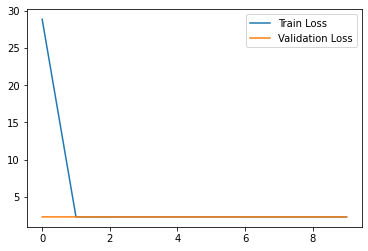

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30147821, Testing Accuracies: 0.11360000 
Testing finish!... plotting testing results


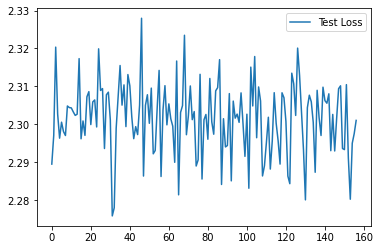

Training VGG on mnist with lr=0.003 optimizer= SGD


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 1 of 10 with 369.05 s
Training loss: 2.30206369, Validation loss: 2.30192262, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 2 of 10 with 368.97 s
Training loss: 2.30163937, Validation loss: 2.30165801, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 3 of 10 with 368.84 s
Training loss: 2.30139576, Validation loss: 2.30151901, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Epoch 4 of 10 with 368.97 s
Training loss: 2.30125559, Validation loss: 2.30144272, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 5 of 10 with 369.02 s
Training loss: 2.30119638, Validation loss: 2.30156769, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 6 of 10 with 369.13 s
Training loss: 2.30115738, Validation loss: 2.30137260, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 7 of 10 with 368.95 s
Training loss: 2.30117838, Validation loss: 2.30141771, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 8 of 10 with 369.15 s
Training loss: 2.30114164, Validation loss: 2.30144384, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 9 of 10 with 369.06 s
Training loss: 2.30116237, Validation loss: 2.30146953, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 10 of 10 with 369.05 s
Training loss: 2.30112914, Validation loss: 2.30140546, Validation Accuracies: 0.11175000 
Avg per epoch ptime: 369.02, total 10 epochs ptime: 3690.20
Training finish!... save and plotting training results


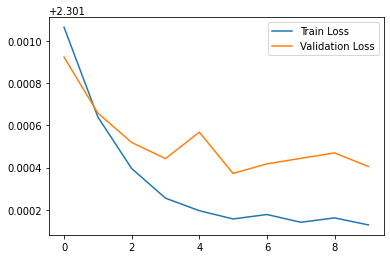

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30091621, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


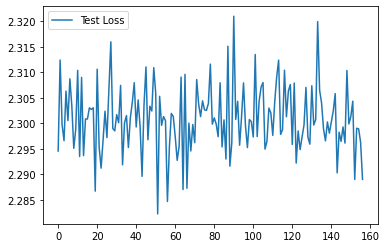

Training VGG on mnist with lr=0.0003 optimizer= Adam


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 1 of 10 with 382.21 s
Training loss: 2.30187784, Validation loss: 2.30173408, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.78it/s]


Epoch 2 of 10 with 382.23 s
Training loss: 2.30144079, Validation loss: 2.30152022, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 3 of 10 with 381.96 s
Training loss: 2.30146525, Validation loss: 2.30151145, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 4 of 10 with 382.08 s
Training loss: 2.30144152, Validation loss: 2.30161400, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 5 of 10 with 382.11 s
Training loss: 2.30137114, Validation loss: 2.30146198, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 6 of 10 with 382.08 s
Training loss: 2.30129237, Validation loss: 2.30163461, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 7 of 10 with 381.99 s
Training loss: 2.30136728, Validation loss: 2.30175000, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.86it/s]


Epoch 8 of 10 with 381.67 s
Training loss: 2.30129484, Validation loss: 2.30154955, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 9 of 10 with 382.16 s
Training loss: 2.30134954, Validation loss: 2.30147555, Validation Accuracies: 0.11175000 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 10 of 10 with 382.08 s
Training loss: 2.30130661, Validation loss: 2.30164387, Validation Accuracies: 0.11175000 
Avg per epoch ptime: 382.06, total 10 epochs ptime: 3820.57
Training finish!... save and plotting training results


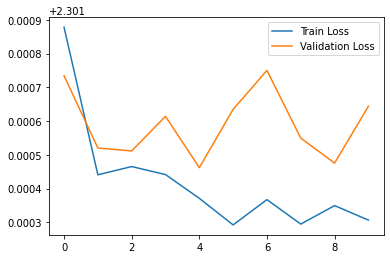

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.75it/s]


Testing loss: 2.30115072, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


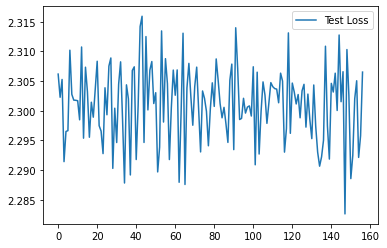

Training VGG on mnist with lr=0.0003 optimizer= SGD


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 1 of 10 with 369.35 s
Training loss: 2.30232064, Validation loss: 2.30243490, Validation Accuracies: 0.10366667 


100%|██████████| 188/188 [00:27<00:00,  6.78it/s]


Epoch 2 of 10 with 369.49 s
Training loss: 2.30221460, Validation loss: 2.30233713, Validation Accuracies: 0.10466667 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 3 of 10 with 369.32 s
Training loss: 2.30219323, Validation loss: 2.30231654, Validation Accuracies: 0.10583333 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 4 of 10 with 369.28 s
Training loss: 2.30211041, Validation loss: 2.30226774, Validation Accuracies: 0.10466667 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 5 of 10 with 369.37 s
Training loss: 2.30204477, Validation loss: 2.30219050, Validation Accuracies: 0.10541667 


100%|██████████| 188/188 [00:27<00:00,  6.78it/s]


Epoch 6 of 10 with 369.60 s
Training loss: 2.30199866, Validation loss: 2.30217288, Validation Accuracies: 0.10675000 


100%|██████████| 188/188 [00:27<00:00,  6.75it/s]


Epoch 7 of 10 with 369.50 s
Training loss: 2.30193810, Validation loss: 2.30202644, Validation Accuracies: 0.11191667 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 8 of 10 with 369.21 s
Training loss: 2.30189840, Validation loss: 2.30202107, Validation Accuracies: 0.11158333 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 9 of 10 with 369.17 s
Training loss: 2.30186050, Validation loss: 2.30200620, Validation Accuracies: 0.11208333 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 10 of 10 with 369.08 s
Training loss: 2.30180772, Validation loss: 2.30200262, Validation Accuracies: 0.11050000 
Avg per epoch ptime: 369.34, total 10 epochs ptime: 3693.37
Training finish!... save and plotting training results


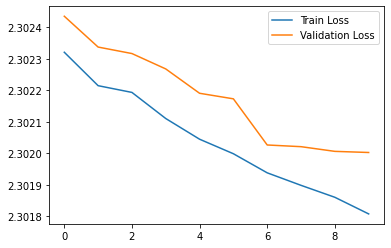

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Testing loss: 2.30181775, Testing Accuracies: 0.11340000 
Testing finish!... plotting testing results


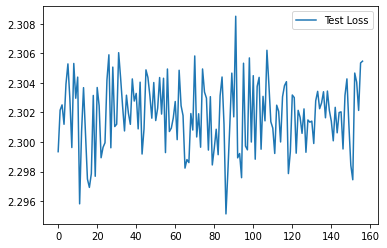

In [ ]:
logger.info("Training VGG on MNIST dataset") 


for lr in [0.3, 0.03, 0.003, 0.0003]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
          print("Already trained on VGG on mnist with lr={} optimizer= {}".format(lr,optimizer))
  
          #model = VGG16(input_channels = 3, num_classes = 10)
          #model.load_state_dict(torch.load(mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"))

        else:
          model = VGG16(input_channels = 3, num_classes = 10)

          if optimizer == 'Adam':
              model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          if optimizer == 'SGD':
              model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          print("Training VGG on mnist with lr={} optimizer= {}".format(lr,optimizer))
      
          model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/mnist_VGG_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

          trained_model, train_hist = train_model(model, model_log_path, mnist_train_loader, mnist_val_loader, criterion, model_optimizer)
        
          print("Training finish!... save and plotting training results")

          with open(mnist_save_dir +'vgg_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
              pickle.dump(train_hist, f)

          logger.info("Saving VGG trained model on  MNIST dataset") 
          torch.save(model.state_dict(), mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

          logger.info("Plotting VGG Model train losses on MNIST") 

          plt.plot(train_hist['model_train_losses'])
          plt.plot(train_hist['model_val_losses'])
          plt.legend(["Train Loss", "Validation Loss"])
          plt.savefig(mnist_fig_dir + "/vgg_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()

          print("Testing VGG trained model")
          test_loss = test_model(model, mnist_test_loader, criterion)
          print("Testing finish!... plotting testing results")
          plt.plot(test_loss)
          plt.legend(["Test Loss"])
          plt.savefig(mnist_fig_dir + "/vgg_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()
        print("========================================================")



# Training CIFAR 10 dataset on VGG

Training VGG on cifar with lr=0.3 optimizer= Adam


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 1 of 10 with 318.63 s
Training loss: 1669467035121392045614983538540544.00000000, Validation loss: 1619703439895346829884127266734080.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 2 of 10 with 318.52 s
Training loss: 1628900717016289137106314984423424.00000000, Validation loss: 1618700052532716665381545905750016.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 3 of 10 with 318.50 s
Training loss: 1629208906398065364251369648685056.00000000, Validation loss: 1619479600426698749233108717928448.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 4 of 10 with 318.57 s
Training loss: 1628791549397718768537514467655680.00000000, Validation loss: 1617237798448247289167877326766080.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 5 of 10 with 318.47 s
Training loss: 1628476328516519481137003698847744.00000000, Validation loss: 1623407139163447009527658920804352.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 6 of 10 with 318.28 s
Training loss: 1629518485986505591280479554764800.00000000, Validation loss: 1617773294742701322206512492314624.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 7 of 10 with 318.48 s
Training loss: 1628819313545537705376102047809536.00000000, Validation loss: 1620694222150363697551916266422272.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 8 of 10 with 318.46 s
Training loss: 1629325423914237032397833313976320.00000000, Validation loss: 1621160570228785515120582188859392.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 9 of 10 with 318.47 s
Training loss: 1628911948351089647114105791709184.00000000, Validation loss: 1619873801537042829610986145579008.00000000, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 10 of 10 with 318.56 s
Training loss: 1628266073932984994851706332250112.00000000, Validation loss: 1621130750756716704771352570101760.00000000, Validation Accuracies: 0.10130000 
Avg per epoch ptime: 318.49, total 10 epochs ptime: 3184.95
Training finish!... save and plotting training results


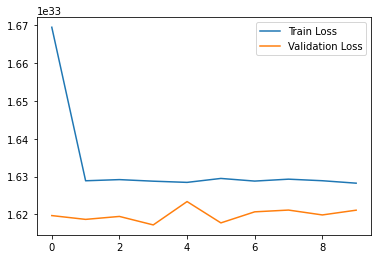

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Testing loss: 1364806866652897788306773241757696.00000000, Testing Accuracies: 0.08920000 
Testing finish!... plotting testing results


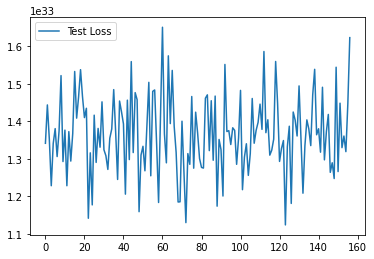

Training VGG on cifar with lr=0.3 optimizer= SGD


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 1 of 10 with 307.73 s
Training loss: 2.30414934, Validation loss: 2.30357708, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 2 of 10 with 307.75 s
Training loss: 2.30388373, Validation loss: 2.30501609, Validation Accuracies: 0.10110000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 3 of 10 with 307.65 s
Training loss: 2.30399998, Validation loss: 2.30291317, Validation Accuracies: 0.09720000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 4 of 10 with 307.83 s
Training loss: 2.30392373, Validation loss: 2.30266735, Validation Accuracies: 0.10410000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 5 of 10 with 307.76 s
Training loss: 2.30378797, Validation loss: 2.30322231, Validation Accuracies: 0.09520000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 6 of 10 with 307.74 s
Training loss: 2.30379602, Validation loss: 2.30438168, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 7 of 10 with 307.87 s
Training loss: 2.30383248, Validation loss: 2.30398747, Validation Accuracies: 0.09680000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 8 of 10 with 307.96 s
Training loss: 2.30376386, Validation loss: 2.30465977, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 9 of 10 with 307.81 s
Training loss: 2.30361698, Validation loss: 2.30376951, Validation Accuracies: 0.09900000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 10 of 10 with 307.84 s
Training loss: 2.30364647, Validation loss: 2.30495289, Validation Accuracies: 0.09900000 
Avg per epoch ptime: 307.79, total 10 epochs ptime: 3077.95
Training finish!... save and plotting training results


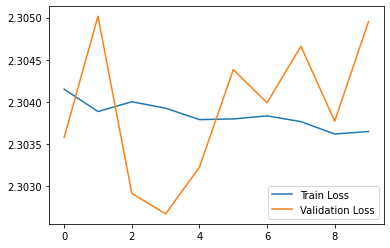

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.79it/s]


Testing loss: 2.30237759, Testing Accuracies: 0.10320000 
Testing finish!... plotting testing results


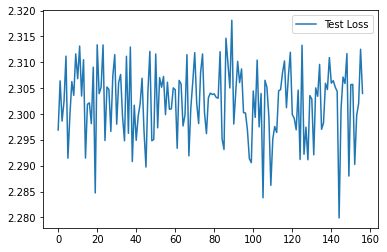

Training VGG on cifar with lr=0.03 optimizer= Adam


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 1 of 10 with 318.35 s
Training loss: 7370830751034930.00000000, Validation loss: 890696.81109098, Validation Accuracies: 0.10410000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 2 of 10 with 318.36 s
Training loss: 36350164.52593652, Validation loss: 20524406.34237294, Validation Accuracies: 0.10410000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 3 of 10 with 318.63 s
Training loss: 8274188.98734393, Validation loss: 2.30595190, Validation Accuracies: 0.09900000 


100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Epoch 4 of 10 with 318.48 s
Training loss: 1991651.14905691, Validation loss: 2.30533368, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 5 of 10 with 318.42 s
Training loss: 447469.87329768, Validation loss: 2.30405818, Validation Accuracies: 0.09830000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 6 of 10 with 318.30 s
Training loss: 55680459.79331104, Validation loss: 15647104.20927980, Validation Accuracies: 0.09840000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 7 of 10 with 318.23 s
Training loss: 11129004428.71898270, Validation loss: 99598508503.86550903, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 8 of 10 with 318.45 s
Training loss: 31526118019.68352509, Validation loss: 66284272.35324891, Validation Accuracies: 0.10400000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 9 of 10 with 318.37 s
Training loss: 6174397.07545973, Validation loss: 2894987057.57582045, Validation Accuracies: 0.09900000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 10 of 10 with 318.31 s
Training loss: 613716439.18402493, Validation loss: 1915808.04540608, Validation Accuracies: 0.09980000 
Avg per epoch ptime: 318.39, total 10 epochs ptime: 3183.89
Training finish!... save and plotting training results


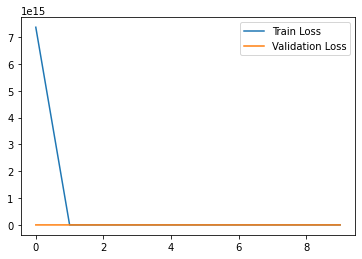

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30515772, Testing Accuracies: 0.10100000 
Testing finish!... plotting testing results


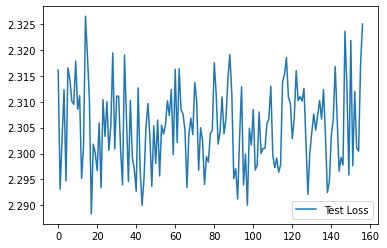

Training VGG on cifar with lr=0.03 optimizer= SGD


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 1 of 10 with 307.85 s
Training loss: 2.30280273, Validation loss: 2.30286837, Validation Accuracies: 0.09640000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 2 of 10 with 307.75 s
Training loss: 2.30276594, Validation loss: 2.30297674, Validation Accuracies: 0.09720000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 3 of 10 with 307.72 s
Training loss: 2.30279537, Validation loss: 2.30274956, Validation Accuracies: 0.09840000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 4 of 10 with 307.77 s
Training loss: 2.30282011, Validation loss: 2.30305173, Validation Accuracies: 0.09460000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 5 of 10 with 307.66 s
Training loss: 2.30279455, Validation loss: 2.30291610, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 6 of 10 with 307.74 s
Training loss: 2.30280777, Validation loss: 2.30307533, Validation Accuracies: 0.09400000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 7 of 10 with 307.64 s
Training loss: 2.30280886, Validation loss: 2.30273649, Validation Accuracies: 0.09560000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 8 of 10 with 307.75 s
Training loss: 2.30273676, Validation loss: 2.30283134, Validation Accuracies: 0.09740000 


100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 9 of 10 with 307.65 s
Training loss: 2.30283373, Validation loss: 2.30279198, Validation Accuracies: 0.09670000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 10 of 10 with 307.75 s
Training loss: 2.30282150, Validation loss: 2.30275793, Validation Accuracies: 0.09580000 
Avg per epoch ptime: 307.73, total 10 epochs ptime: 3077.30
Training finish!... save and plotting training results


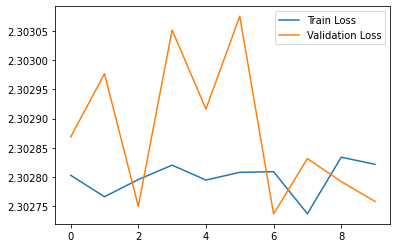

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Testing loss: 2.30208388, Testing Accuracies: 0.11050000 
Testing finish!... plotting testing results


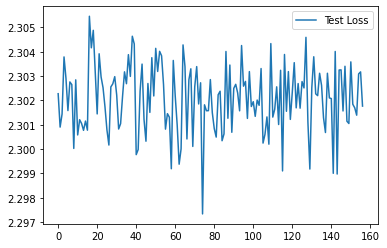

Training VGG on cifar with lr=0.003 optimizer= Adam


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 1 of 10 with 318.45 s
Training loss: 96.83202790, Validation loss: 2.30273919, Validation Accuracies: 0.10150000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 2 of 10 with 318.43 s
Training loss: 2.30299980, Validation loss: 2.30294679, Validation Accuracies: 0.09950000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 3 of 10 with 318.47 s
Training loss: 2.30309898, Validation loss: 2.30275220, Validation Accuracies: 0.10280000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 4 of 10 with 318.59 s
Training loss: 2.30293667, Validation loss: 2.30290929, Validation Accuracies: 0.09820000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 5 of 10 with 318.49 s
Training loss: 2.30293067, Validation loss: 2.30317249, Validation Accuracies: 0.09900000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 6 of 10 with 318.40 s
Training loss: 2.30289425, Validation loss: 2.30259332, Validation Accuracies: 0.10010000 


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 7 of 10 with 318.39 s
Training loss: 2.30299368, Validation loss: 2.30281077, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 8 of 10 with 318.52 s
Training loss: 2.30292943, Validation loss: 2.30285694, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 9 of 10 with 318.44 s
Training loss: 2.30290337, Validation loss: 2.30301467, Validation Accuracies: 0.10130000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 10 of 10 with 318.59 s
Training loss: 2.30298817, Validation loss: 2.30278640, Validation Accuracies: 0.10010000 
Avg per epoch ptime: 318.48, total 10 epochs ptime: 3184.77
Training finish!... save and plotting training results


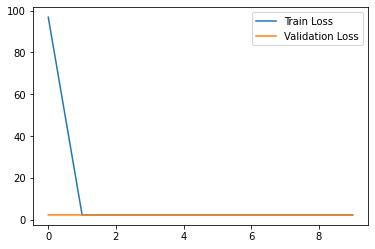

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.79it/s]


Testing loss: 2.30316823, Testing Accuracies: 0.09800000 
Testing finish!... plotting testing results


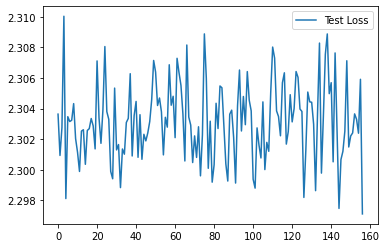

Training VGG on cifar with lr=0.003 optimizer= SGD


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 1 of 10 with 307.80 s
Training loss: 2.30265979, Validation loss: 2.30259842, Validation Accuracies: 0.10240000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 2 of 10 with 307.67 s
Training loss: 2.30259855, Validation loss: 2.30267295, Validation Accuracies: 0.09850000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 3 of 10 with 307.76 s
Training loss: 2.30261463, Validation loss: 2.30268176, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 4 of 10 with 307.80 s
Training loss: 2.30257515, Validation loss: 2.30263074, Validation Accuracies: 0.09850000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 5 of 10 with 307.66 s
Training loss: 2.30258205, Validation loss: 2.30263876, Validation Accuracies: 0.10220000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 6 of 10 with 307.87 s
Training loss: 2.30260851, Validation loss: 2.30271537, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 7 of 10 with 307.77 s
Training loss: 2.30257071, Validation loss: 2.30270967, Validation Accuracies: 0.09580000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 8 of 10 with 307.78 s
Training loss: 2.30262782, Validation loss: 2.30268507, Validation Accuracies: 0.10010000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 9 of 10 with 307.96 s
Training loss: 2.30260051, Validation loss: 2.30279802, Validation Accuracies: 0.09170000 


100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Epoch 10 of 10 with 307.81 s
Training loss: 2.30262953, Validation loss: 2.30272722, Validation Accuracies: 0.09470000 
Avg per epoch ptime: 307.79, total 10 epochs ptime: 3077.87
Training finish!... save and plotting training results


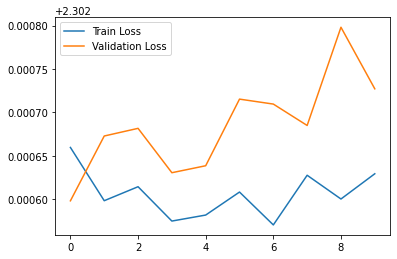

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30247505, Testing Accuracies: 0.10170000 
Testing finish!... plotting testing results


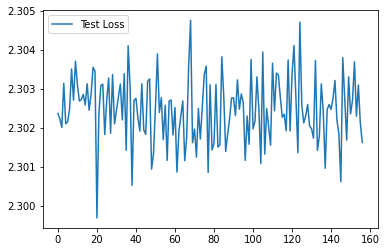

Training VGG on cifar with lr=0.0003 optimizer= Adam


100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 1 of 10 with 318.40 s
Training loss: 2.30308313, Validation loss: 2.30318342, Validation Accuracies: 0.09710000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 2 of 10 with 318.44 s
Training loss: 2.30290926, Validation loss: 2.30312234, Validation Accuracies: 0.09450000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 3 of 10 with 318.51 s
Training loss: 2.30288520, Validation loss: 2.30294592, Validation Accuracies: 0.09710000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 4 of 10 with 318.60 s
Training loss: 2.30280903, Validation loss: 2.30285599, Validation Accuracies: 0.09650000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 5 of 10 with 318.52 s
Training loss: 2.30275111, Validation loss: 2.30274059, Validation Accuracies: 0.09950000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 6 of 10 with 318.61 s
Training loss: 2.30272177, Validation loss: 2.30284281, Validation Accuracies: 0.09580000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 7 of 10 with 318.55 s
Training loss: 2.30271150, Validation loss: 2.30284245, Validation Accuracies: 0.09380000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 8 of 10 with 318.52 s
Training loss: 2.30268168, Validation loss: 2.30275585, Validation Accuracies: 0.09560000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 9 of 10 with 318.57 s
Training loss: 2.30266841, Validation loss: 2.30273478, Validation Accuracies: 0.09970000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 10 of 10 with 318.55 s
Training loss: 2.30269774, Validation loss: 2.30279870, Validation Accuracies: 0.09290000 
Avg per epoch ptime: 318.53, total 10 epochs ptime: 3185.28
Training finish!... save and plotting training results


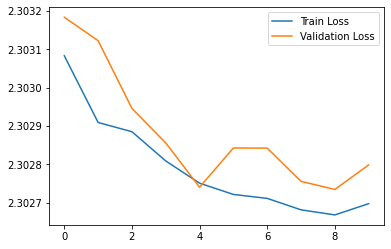

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Testing loss: 2.30251132, Testing Accuracies: 0.09980000 
Testing finish!... plotting testing results


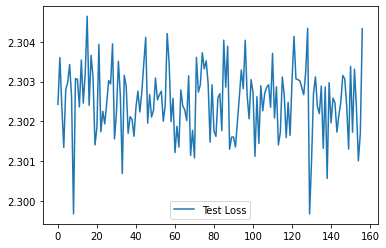

Training VGG on cifar with lr=0.0003 optimizer= SGD


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 1 of 10 with 307.85 s
Training loss: 2.30268663, Validation loss: 2.30249241, Validation Accuracies: 0.10020000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 2 of 10 with 307.78 s
Training loss: 2.30264102, Validation loss: 2.30252927, Validation Accuracies: 0.09980000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 3 of 10 with 307.78 s
Training loss: 2.30269088, Validation loss: 2.30251966, Validation Accuracies: 0.10120000 


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Epoch 4 of 10 with 307.92 s
Training loss: 2.30264140, Validation loss: 2.30251354, Validation Accuracies: 0.09930000 


100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Epoch 5 of 10 with 307.96 s
Training loss: 2.30263897, Validation loss: 2.30256807, Validation Accuracies: 0.09650000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 6 of 10 with 307.84 s
Training loss: 2.30262332, Validation loss: 2.30251489, Validation Accuracies: 0.10320000 


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 7 of 10 with 307.78 s
Training loss: 2.30265938, Validation loss: 2.30251987, Validation Accuracies: 0.10090000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 8 of 10 with 307.90 s
Training loss: 2.30263610, Validation loss: 2.30258927, Validation Accuracies: 0.09850000 


100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 9 of 10 with 307.78 s
Training loss: 2.30262072, Validation loss: 2.30252081, Validation Accuracies: 0.09940000 


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Epoch 10 of 10 with 307.92 s
Training loss: 2.30264168, Validation loss: 2.30243251, Validation Accuracies: 0.10750000 
Avg per epoch ptime: 307.85, total 10 epochs ptime: 3078.51
Training finish!... save and plotting training results


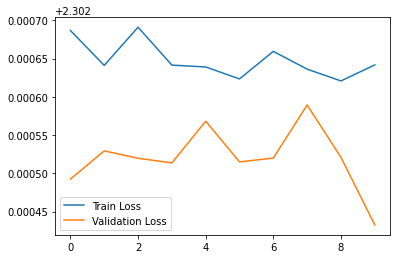

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.72it/s]


Testing loss: 2.30286388, Testing Accuracies: 0.09230000 
Testing finish!... plotting testing results


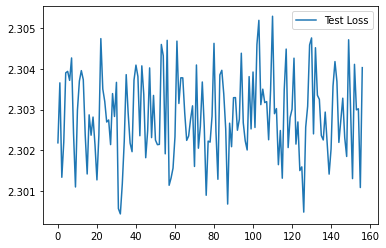

In [ ]:
logger.info("Trianing VGG on CIFAR dataset") 


for lr in [0.3, 0.03, 0.003, 0.0003]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
          print("Already trained on VGG on cifar with lr={} optimizer= {}".format(lr,optimizer))
          print("Loading Model")
          model = VGG16(input_channels = 3, num_classes = 10)
          model.load_state_dict(torch.load(cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"))
          

        else:
          model = VGG16(input_channels = 3, num_classes = 10)

          if optimizer == 'Adam':
              model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          if optimizer == 'SGD':
              model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          print("Training VGG on cifar with lr={} optimizer= {}".format(lr,optimizer))
      
          model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/cifar_VGG_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

          trained_model, train_hist = train_model(model, model_log_path, cifar_train_loader, cifar_val_loader, criterion, model_optimizer)
        
          print("Training finish!... save and plotting training results")

          with open(cifar_save_dir +'vgg_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
              pickle.dump(train_hist, f)

          logger.info("Saving VGG trained model on CIFAR dataset") 
          torch.save(model.state_dict(), cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

          logger.info("Plotting VGG Model train losses on CIFAR") 

          plt.plot(train_hist['model_train_losses'])
          plt.plot(train_hist['model_val_losses'])
          plt.legend(["Train Loss", "Validation Loss"])
          plt.savefig(cifar_fig_dir + "/vgg_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()

          print("Testing VGG trained model")
          test_loss = test_model(model, mnist_test_loader, criterion)
          print("Testing finish!... plotting testing results")
          plt.plot(test_loss)
          plt.legend(["Test Loss"])
          plt.savefig(cifar_fig_dir + "/vgg_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()
        print("========================================================")

